# Dicoding Text Classification with LSTM Submission

## Coronavirus tweets NLP - Text Classification
## source : Kaggle
## link to dataset : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

### Dataset contains train and test set
### But the test set only has 3680 samples and Dicoding requires 20% valid set
### Hence i dont not use the test set
### I create a new validation set from train set (contains 40.000+ samples)
### So my validation set will contain 8.000 samples

In [1]:
#install tweet-prepocessing library first for faster tweet cleaning
!pip install tweet-preprocessor

#install NLTK for string processing
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import re
import string
import preprocessor as p
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load the dataset

#An error occured when i first loaded the data, UnicodeDecodeError
#turns out the csv isn't in utf-8 but latin-1
#added encoding latin-1 argument 
corona = pd.read_csv('/content/Corona_NLP_train.csv', encoding="Latin-1")

In [4]:
#examine
print(corona.head())

   UserName  ...           Sentiment
0      3799  ...             Neutral
1      3800  ...            Positive
2      3801  ...            Positive
3      3802  ...            Positive
4      3803  ...  Extremely Negative

[5 rows x 6 columns]


### Data Wrangling

    Steps:
    1. Take 1 feature and 1 target (original tweet and sentiment)
    2. Check for datashape
    3. Split feature and label (target) into separate variable 
    4. Check for train set target (label) cardinality if its less or equal 5, use One Hot encoding,
        otherwise, use Label Encoding
    5. Reduce cardinality of target from 5 to 3
    6. Clean The original Tweet features
        SInce this is tweets from people, there will be a lot of useless character
        such as # (hashtag), @ (twitter username), 
        http (sometimes people put url adress to another site or another tweet), 
        remove non charachter such as /n (new line)
        remove punctuation
    

In [5]:
#lets take two important columns to use
#and create new dataframe replacing the original df 
#Original Tweet and Sentiment

corona = corona[['OriginalTweet', 'Sentiment']]

In [6]:
#check for shape
print(f'Train dataset shape: {corona.shape}')

Train dataset shape: (41157, 2)


In [7]:
#Check our Target (sentiment) cardinality
sentiment = list(corona['Sentiment'].unique())
print(f'The Sentiment Cardinality is {str(len(sentiment))}\n')
print(sentiment[:20])

The Sentiment Cardinality is 5

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']


In [8]:
#Cardinality Reduction
#cardinality of target is 5, 
#i want to reduce it to 3 by merging extreme sentiments with its reguler counterparts
#e.g extremely negative becomes negative and extremely positive becomes positive

corona['Sentiment'] = corona['Sentiment'].apply(lambda x: 'Positive' if x == 'Extremely Positive' else x)
corona['Sentiment'] = corona['Sentiment'].apply(lambda x: 'Negative' if x == 'Extremely Negative' else x)
print(corona.head())

                                       OriginalTweet Sentiment
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral
1  advice Talk to your neighbours family to excha...  Positive
2  Coronavirus Australia: Woolworths to give elde...  Positive
3  My food stock is not the only one which is emp...  Positive
4  Me, ready to go at supermarket during the #COV...  Negative


In [9]:
#Check our Target (Genre) cardinality again
sentiment = list(corona['Sentiment'].unique())
print(f'The Sentiment Cardinality is {str(len(sentiment))}\n')
print(sentiment[:20])
print(f'\n Train dataset shape: {corona.shape}')

The Sentiment Cardinality is 3

['Neutral', 'Positive', 'Negative']

 Train dataset shape: (41157, 2)


In [10]:
#Cardinality is 3, OHE will be used
#using pandas get_dummies instead of sklearn OHE because it's faster

sentiment = pd.get_dummies(corona['Sentiment'])
corona = pd.concat([corona, sentiment], axis=1)
corona = corona.drop(columns='Sentiment', axis=1)

In [11]:
#rearrange target column for easier comprehension
corona= corona[['OriginalTweet', 'Negative', 'Neutral', 'Positive']]
print(corona.head() )


                                       OriginalTweet  ...  Positive
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...  ...         0
1  advice Talk to your neighbours family to excha...  ...         1
2  Coronavirus Australia: Woolworths to give elde...  ...         1
3  My food stock is not the only one which is emp...  ...         1
4  Me, ready to go at supermarket during the #COV...  ...         0

[5 rows x 4 columns]


## Cleaning Original Tweet
    steps:
    1. make functions for cleaning tweets for reproducibility purpose. function body:
        1.clear any tweets related tags such as #, @, http, etc using twitter-prepocessing library
        2. remove any punctuation
        3. remove any string digits
        4. remove any stop words using NLTK library
        5. remove any trailing white space
        6. remove any empty rows in tweet column as a result of above operations, if any
        
    2. Call the function to clean the datase

In [12]:
#Since i have to clean both original tweets from dataset
#i will create a tweet cleaning function for reproducibility

def tweet_cleaner(df, tweet_column):
    df[tweet_column] = df[tweet_column].apply(lambda x: re.sub(r'(\W)\1{2,}', r'\1', x)) 
    df[tweet_column] = df[tweet_column].apply(lambda x: re.sub(r'(\w)\1{2,}', r'\1\1', x)) 
    #remove any tweet related tags, such as hashtag, mention, http, etc
    df[tweet_column]  = df[tweet_column].apply(lambda x : p.clean(x)) 

    #remove any punctuation
    punctuation = str.maketrans('','',string.punctuation)
    df[tweet_column] = df.apply(lambda x : x[tweet_column].translate(punctuation), axis = 1) 

    #remove any number, so we only take string
    number = str.maketrans('','',string.digits)
    df[tweet_column] = df.apply(lambda x : x[tweet_column].translate(number), axis = 1) 

    #remove stopwords
    stop_words = set(stopwords.words('english'))
    #split and make every tweets into list of words
    df[tweet_column] = df[tweet_column].apply(lambda x : x.split())
    #now remove stopwords and join them back as string
    df[tweet_column] = df[tweet_column].apply(
        lambda x : ' '.join(i.lower() for i in x if not i.lower() in stop_words))

    #remove any extra trailing white space with strip
    df[tweet_column] = df[tweet_column].apply(lambda x : x.strip())
    
    #remove any empty rows as a result of previous cleaning operations
    df[tweet_column] = df[tweet_column].replace('', np.nan) #fill empty string rows with np.nan
    df = df.dropna(subset=[tweet_column]) #remove them
    
    return df

In [13]:
#call the function
corona = tweet_cleaner(corona, 'OriginalTweet')

In [14]:
#examine
print(corona.head())
#success cleaning the tweets

                                       OriginalTweet  ...  Positive
1  advice talk neighbours family exchange phone n...  ...         1
2  coronavirus australia woolworths give elderly ...  ...         1
3  food stock one emptyplease dont panic enough f...  ...         1
4  ready go supermarket outbreaknot im paranoid f...  ...         0
5  news regions first confirmed covid case came s...  ...         1

[5 rows x 4 columns]


## Model Building

In [15]:
#Split the tweet and its label

features = corona['OriginalTweet'].values
target = corona[['Negative', 'Neutral', 'Positive']].values

In [16]:
#perform train and valid set split, 80-20 (Dicoding requirements)
x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42)

In [17]:
#Tokenizer
 
tokenizer = Tokenizer(num_words=25000, oov_token='OOV')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_valid)
 
train_sequence= tokenizer.texts_to_sequences(x_train)
test_sequence = tokenizer.texts_to_sequences(x_valid)


train_padded= pad_sequences(train_sequence) 
test_padded = pad_sequences(test_sequence)


In [18]:
#LSTM Model
model = keras.Sequential([
    layers.Embedding(input_dim=25000, output_dim=32),
    layers.LSTM(256),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
# Add early stop to prevent overfitting
minimum_change = 0.01 #minimum change to be considered an improvement
epoch_stop = 5 #number of epoch to wait before stopping
early_stop = EarlyStopping(
    min_delta = minimum_change, 
    patience= epoch_stop, 
    restore_best_weights=True,
)

In [21]:
num_epochs = 30
steps_per_epoch = 20
history = model.fit(train_padded, 
                    y_train, 
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=(test_padded, y_valid), 
                    validation_steps=10,
                    callbacks=[early_stop],
                    verbose=2)

Epoch 1/30
20/20 - 57s - loss: 1.0333 - accuracy: 0.4300 - val_loss: 0.9922 - val_accuracy: 0.4400
Epoch 2/30
20/20 - 55s - loss: 0.9535 - accuracy: 0.4834 - val_loss: 0.9171 - val_accuracy: 0.5740
Epoch 3/30
20/20 - 54s - loss: 0.7620 - accuracy: 0.6650 - val_loss: 0.7246 - val_accuracy: 0.7060
Epoch 4/30
20/20 - 55s - loss: 0.4526 - accuracy: 0.8325 - val_loss: 0.5863 - val_accuracy: 0.7762
Epoch 5/30
20/20 - 54s - loss: 0.2715 - accuracy: 0.9126 - val_loss: 0.5748 - val_accuracy: 0.8059
Epoch 6/30
20/20 - 55s - loss: 0.1841 - accuracy: 0.9468 - val_loss: 0.6039 - val_accuracy: 0.8104
Epoch 7/30
20/20 - 55s - loss: 0.1439 - accuracy: 0.9599 - val_loss: 0.6682 - val_accuracy: 0.8050
Epoch 8/30
20/20 - 55s - loss: 0.1095 - accuracy: 0.9715 - val_loss: 0.7375 - val_accuracy: 0.8040
Epoch 9/30
20/20 - 55s - loss: 0.0897 - accuracy: 0.9772 - val_loss: 0.8165 - val_accuracy: 0.7989
Epoch 10/30
20/20 - 56s - loss: 0.0768 - accuracy: 0.9806 - val_loss: 0.9101 - val_accuracy: 0.7910


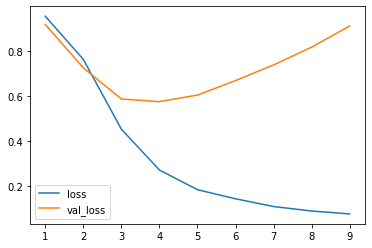

In [22]:
#loss 
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
plt.show()

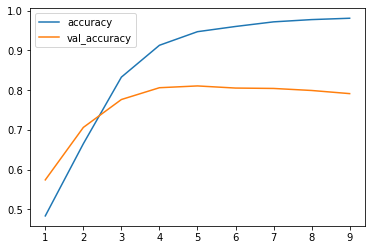

In [23]:
#accuracy 
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [24]:
#Best validation loss and accuracy score
print(("Best Validation Loss: {:0.2f}" +"\nBest Validation Accuracy: {:0.2f}").format(history_df['val_loss'].min(), history_df['val_accuracy'].max()))

Best Validation Loss: 0.57
Best Validation Accuracy: 0.81
